In [1]:
from ipynb.fs.full.gbs import *

# Experiments

### Experimental Setup

```
                       ┌─────────────┐
[Detector] ◄──[ent]──► │             │──► [Detector]
[Detector] ◄──[ent]──► │             │──► [Detector]
[Detector] ◄──[ent]──► │ Haar-Random │──► [Detector]
[Detector] ◄──[ent]──► │   Unitary   │──► [Detector]
[Detector] ◄──[ent]──► │             │──► [Detector]
[Detector] ◄──[ent]──► │             │──► [Detector]
                       └─────────────┘
```

### QM Simulation

Let $k$ be the number of entanglement sources. 
Then, the initial state is 
$$2^{-k/2}(|HH\rangle+|VV\rangle)^{\otimes k} = 2^{-k/2}(|1010\rangle+|0101\rangle)^{\otimes k},$$
but reordered so the left (first two) modes of each ent come first, followed by all the right (second two) modes. 
Mathematically, this is 
$$\frac{1}{\sqrt{2^{k}}} \sum_{x \in S} | xx \rangle$$
Where 
$S 
:= \left\{ x \in \{0,1\}^{2k} : \forall i \in \{1, \dots, k\},\ x_{2i-1} \ne x_{2i} \right\} 
= \{01,10\}^{k}$.

We then apply a $2k \times 2k$ Haar-random unitary $U_\text{haar}$ to the right modes by applying the $4k \times 4k$ unitary $U = I \oplus U_\text{haar}$.

Note that there are $2k$ photons in the system, with $k$ of those passing through $U_\text{haar}$, and no mode has more than one photon in it initially.


In [ ]:
def esthru_no_heralding_or_postselection(num_src, haar_U=None, N=1000):
    '''[DEPRECATED]
    Entanglement Sources Through Haar-Random Unitary (ESTHRU) experiment.
    Compares probability distributions for QM and Stochastic simulation models.
    Simulates entanglement sources instead of using them for heralding.
    No postselection. '''
    
    m = 4*num_src  # there are 4 modes per entanglement source (rH,rV,lH,lV)
    rm = 2*num_src # two modes exit the right side of each ent (rH,rV)
    n = 2*num_src  # each ent sends one photon out each side

    if not haar_U:
        haar_U = qr_haar(rm)
    if not is_unitary(haar_U):
        raise ValueError('haar_U must be unitary.')
    if haar_U.shape != (rm, rm):
        raise ValueError(f'Unitary must act on {rm} modes.')
        
    #### print(haar_U)

    # Simulate haar_U using QM ("theory")
    # prepare initial state
    basis_states = get_fock_basis_states(n, m)
    non_zero_amp_states = []
    for i in range(2**num_src):
        state = np.zeros(m, dtype=int)
        for digit in range(num_src):
            # each entanglement source either releases H light
            # in both directions or V light in both directions
            ent_index = 2*digit
            h_or_v = (i % 2)
            state[ent_index + h_or_v] = 1
            state[rm + ent_index + h_or_v] = 1
            i >>= 1
        non_zero_amp_states.append(tuple(state))
        
    #### print(non_zero_amp_states)

    initial_state = np.array([(state in non_zero_amp_states) for state in basis_states], dtype=complex) / sqrt(2**num_src)
    #### print('init', initial_state)
    U = direct_sum(np.eye(rm), haar_U) # unitary acting on all modes
    hsu_mat = get_hilbert_space_unitary_matrix(U, n)
    #### print(hsu_mat)
    final_state = hsu_mat @ initial_state
    
    final_probs = conj(final_state) * final_state
    qm_distr = defaultdict(lambda: 0)
    for i,state in enumerate(basis_states):
        detection_event = tuple([(1 if x > 0 else 0) for x in state[rm:]]) 
        qm_distr[detection_event] += final_probs[i]

    # Spoof haar_U using stochastic mechanics ("experiment")
    ents = [ent(N, r=1) for i in range(num_src)]
    l_ents = np.concatenate(tuple([ent[0] for ent in ents]))
    r_ents = np.concatenate(tuple([ent[1] for ent in ents]))
    r_ents = haar_U @ r_ents
    dl = threshold_detector(l_ents)
    dr = threshold_detector(r_ents)
    
    stoch_distr = Counter(map(tuple, dr.T))
    stoch_normalization = N - stoch_distr[tuple(np.zeros(rm))]
    
    distrs_sorted = []
    for det_event in qm_distr:
        distrs_sorted.append((qm_distr[det_event], stoch_distr[det_event]/N, ''.join(map(str,det_event))))
    distrs_sorted = sorted(distrs_sorted)
    
    labels = []
    qm_data = []
    stoch_data = []
    for qm_pt, stoch_pt, det_event in distrs_sorted:
        labels.append(det_event)
        qm_data.append(qm_pt)
        stoch_data.append(stoch_pt)
        
    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, qm_data, width, label='QM')
    rects2 = ax.bar(x + width/2, stoch_data, width, label='Spoof')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Probabilities')
    ax.set_title('Comparing QM and Spoof')
    ax.set_xticks(x, labels, rotation=90)
    ax.legend()

    #ax.bar_label(rects1, padding=3)
    #ax.bar_label(rects2, padding=3)

    fig.tight_layout()

    plt.show()
    
    # sort by what's heralded
#     counts = defaultdict(lambda: defaultdict(lambda: 0))
#     for i in range(N):
#         counts[tuple(dl[i])][tuple(dr[i])] += 1
    
    #options
    # 1) assume heralded state (eg [0,1,0,1]) is true Fock state (not something indistinguishable like [0,3,0,3])
    # 2) assume true state is (equal?) superposition of all states consistent with heralded state (unconserved photon number means many hsu's)
    # 3) assume true state is (equal?) superposition of all states with num_src photons consistent with heralded state
    
    #QM sim it, turn amps to probs, then graph output pr distr behind stochastic sim raw counts normalized
    
esthru_no_heralding_or_postselection(2, N=1000000)

In [ ]:
def focky_estu(
        num_src, 
        U=None, 
        heralds=None, 
        postselection=None, 
        r=1, 
        herald_gamma=DEFAULT_MEAS_THRESH, 
        out_gamma=DEFAULT_MEAS_THRESH, 
        N=1000
    ):
    '''[DEPRECATED]
    Entanglement Sources Through Unitary (ESTU) experiment.
    Defaults to applying Haar-Random Unitary and graphing results for all possible lossless heralds.
    Compares probability distributions for QM and Stochastic simulation models.
    Uses heralding and postselection. '''
    
    m = 2*num_src   # two modes exit the right side of each ent (rH,rV)
    n = num_src     # each ent sends one photon to the right

    if U is None:
        U = qr_haar(m)
    if not is_unitary(U):
        raise ValueError('U must be unitary.')
    if U.shape != (m, m):
        raise ValueError(f'Unitary must act on {m} modes.')
    
    if heralds is None:
        all_possible_heralds = []
        for i in range(2**n):
            state = [0]*m
            for digit in range(n):
                # each entanglement source either releases H light
                # in both directions or V light in both directions
                ent_index = 2*digit
                h_or_v = (i % 2)
                state[ent_index + h_or_v] = 1
                i >>= 1
            all_possible_heralds.append(tuple(state))
        heralds = all_possible_heralds
        
    if postselection is None:
        postselection = get_fock_basis_states(n, m)
    
    ######################################
    ### Simulate U using QM ("theory") ###
    ######################################

    hsu = HilbertSpaceUnitary(U, n, postselection)
    
    qm_distrs = defaultdict(lambda: defaultdict(lambda: 0))
    
    for initial_state in heralds:
        final_state = hsu.apply(initial_state)
        qm_normalization = 0
        for measurement_outcome in final_state:
            amp = final_state[measurement_outcome]
            probability = amp * conj(amp)
            qm_distrs[initial_state][measurement_outcome] = probability
            qm_normalization += probability
        if qm_normalization != 0:
            for measurement_outcome in qm_distrs[initial_state]:
                qm_distrs[initial_state][measurement_outcome] /= qm_normalization

    #########################################################
    ### Spoof U using stochastic mechanics ("experiment") ###
    #########################################################
    
    ents = [ent(N, r=r) for i in range(num_src)]
    l_ents = np.concatenate(tuple([ent[0] for ent in ents]))
    r_ents = np.concatenate(tuple([ent[1] for ent in ents]))
    r_ents = U @ r_ents
    dl = threshold_detector(l_ents, herald_gamma)
    dr = threshold_detector(r_ents, out_gamma)
    
    stoch_distrs = defaultdict(lambda: defaultdict(lambda: 0))
    
    for herald in heralds:
        herald_mask = trials_with_outcome(herald, dl)
        counts = Counter(map(tuple, dr.T[herald_mask]))
        stoch_normalization = 0
        for outcome in counts.keys():
            stoch_distrs[herald][outcome] = counts[outcome]
        for outcome in postselection:
            stoch_normalization += counts[outcome]
        if stoch_normalization != 0:
            for outcome in postselection:
                stoch_distrs[herald][outcome] /= stoch_normalization
        print(f'Out of {sum(herald_mask)} trials heralding {herald}, {stoch_normalization} preserved photon number.')
    
    #####################
    ### Graph results ###
    #####################
    
    for herald in heralds:
        distrs_sorted = []
        for det_event in postselection:
            distrs_sorted.append(
                (qm_distrs[herald][det_event], 
                 stoch_distrs[herald][det_event], 
                 ''.join(map(str,det_event)))
            )
        distrs_sorted = sorted(distrs_sorted)
    
        labels = []
        qm_data = []
        stoch_data = []
        for qm_pt, stoch_pt, det_event in distrs_sorted:
            labels.append(det_event)
            qm_data.append(qm_pt)
            stoch_data.append(stoch_pt)

        x = np.arange(len(labels))  # the label locations
        width = 0.35  # the width of the bars

        fig, ax = plt.subplots()
        rects1 = ax.bar(x - width/2, qm_data, width, label='QM', color='gray')
        rects2 = ax.bar(x + width/2, stoch_data, width, label='Spoof', color='orangered')

        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel('Probabilities')
        ax.set_title(f'Comparing QM and Spoof, Heralding {herald}')
        ax.set_xticks(x, labels, rotation=90)
        ax.legend()

        #ax.bar_label(rects1, padding=3)
        #ax.bar_label(rects2, padding=3)

        fig.tight_layout()

        plt.show()
    
    return qm_distrs, stoch_distrs

In [20]:
def hellinger_dist(p, q):
    p = np.array(p)
    q = np.array(q)
    return np.linalg.norm(sqrt(p) - sqrt(q)) / sqrt(2)

In [27]:
def estu_v2(
    num_src, 
    U=None, 
    heralds=None, 
    r=1, 
    herald_gamma=DEFAULT_MEAS_THRESH, 
    out_gamma=DEFAULT_MEAS_THRESH, 
    N=1000
):
    '''Entanglement Sources Through Unitary (ESTU) experiment.
    Defaults to applying Haar-Random Unitary and graphing results for all 
    possible lossless heralds with no postselection.
    Compares probability distributions for QM and Stochastic simulation models.
    Uses heralding and 0/1 photon counts, but no postselection.'''
    
    m = 2*num_src   # two modes exit the right side of each ent (rH,rV)
    n = num_src     # each ent sends one photon to the right

    if U is None:
        U = qr_haar(m)
    if not is_unitary(U):
        raise ValueError('U must be unitary.')
    if U.shape != (m, m):
        raise ValueError(f'Unitary must act on {m} modes.')
    
    if heralds is None:
        all_possible_heralds = []
        for i in range(2**n):
            state = [0]*m
            for digit in range(n):
                # each entanglement source either releases H light
                # in both directions or V light in both directions
                ent_index = 2*digit
                h_or_v = (i % 2)
                state[ent_index + h_or_v] = 1
                i >>= 1
            all_possible_heralds.append(tuple(state))
        heralds = all_possible_heralds
        
    all_det_events = set()
    
    ######################################
    ### Simulate U using QM ("theory") ###
    ######################################

    hsu = HilbertSpaceUnitary(U, n)
    
    qm_distrs = defaultdict(lambda: defaultdict(lambda: 0))
    
    for initial_state in heralds:
        final_state = hsu.apply(initial_state)
        qm_normalization = 0
        for fock_outcome in final_state:
            amp = final_state[fock_outcome]
            probability = amp * conj(amp)
            det_event = tuple([(1 if photon_num > 0 else 0) for photon_num in fock_outcome])
            qm_distrs[initial_state][det_event] += probability
            all_det_events.add(det_event)

    #########################################################
    ### Spoof U using stochastic mechanics ("experiment") ###
    #########################################################
    
    ents = [ent(N, r=r) for i in range(num_src)]
    l_ents = np.concatenate(tuple([ent[0] for ent in ents]))
    r_ents = np.concatenate(tuple([ent[1] for ent in ents]))
    r_ents = U @ r_ents
    dl = threshold_detector(l_ents, herald_gamma)
    dr = threshold_detector(r_ents, out_gamma)
    
    stoch_distrs = defaultdict(lambda: defaultdict(lambda: 0))
    
    for herald in heralds:
        herald_mask = trials_with_outcome(herald, dl)
        counts = Counter(map(tuple, dr.astype(int).T[herald_mask]))
        stoch_normalization = 0
        for det_event in counts.keys():
            stoch_distrs[herald][det_event] = counts[det_event]
            stoch_normalization += counts[det_event]
            all_det_events.add(det_event)
        if stoch_normalization != 0:
            for det_event in stoch_distrs[herald]:
                stoch_distrs[herald][det_event] /= stoch_normalization
    
    #####################
    ### Graph results ###
    #####################
    
    hellinger_dists = []
    
    for herald in heralds:
        distrs_sorted = []
        obs_pr_distr = []
        exp_pr_distr = []
        for det_event in all_det_events:
            distrs_sorted.append(
                (qm_distrs[herald][det_event], 
                 stoch_distrs[herald][det_event], 
                 ''.join(map(str,det_event)))
            )
            obs_pr_distr.append(stoch_distrs[herald][det_event])
            exp_pr_distr.append(qm_distrs[herald][det_event])
        distrs_sorted = sorted(distrs_sorted)
        hellinger_dists.append(hellinger_dist(np.array(obs_pr_distr), np.array(exp_pr_distr)))
        #stat, p_value = chisquare(chi_square_obs, chi_square_exp)
    
        labels = []
        qm_data = []
        stoch_data = []
        for qm_pt, stoch_pt, det_event in distrs_sorted:
            labels.append(det_event)
            qm_data.append(qm_pt)
            stoch_data.append(stoch_pt)

        x = np.arange(len(labels))  # the label locations
        width = 0.35  # the width of the bars

        fig, ax = plt.subplots()
        rects1 = ax.bar(x - width/2, qm_data, width, label='QM', color='gray')
        rects2 = ax.bar(x + width/2, stoch_data, width, label='Spoof', color='orangered')

        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel('Probabilities')
        ax.set_title(f'Comparing QM and Spoof, Heralding {herald}')
        ax.set_xticks(x, labels, rotation=90)
        ax.legend()

        #ax.bar_label(rects1, padding=3)
        #ax.bar_label(rects2, padding=3)

        fig.tight_layout()

        #plt.show()
        #print(f"Hellinger distance for herald {herald}: {hellinger_dists[-1]}")
        
    print(f"Avg Hellinger distance: {sum(hellinger_dists)/len(hellinger_dists)}")
    
    return qm_distrs, stoch_distrs

Avg Hellinger distance: 0.27880954517309897


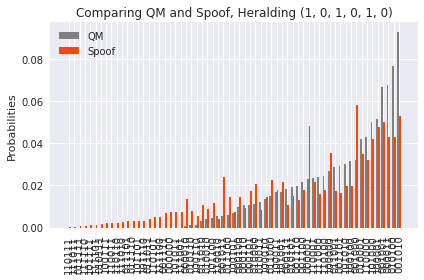

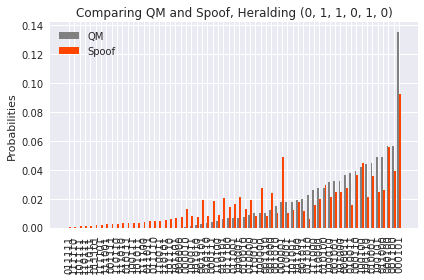

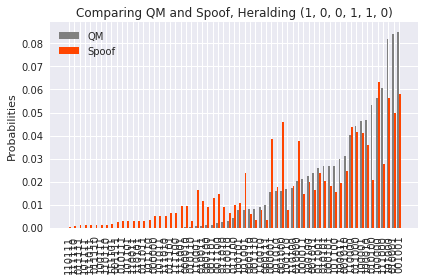

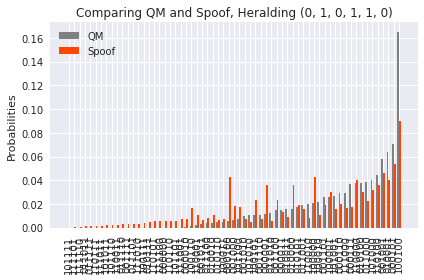

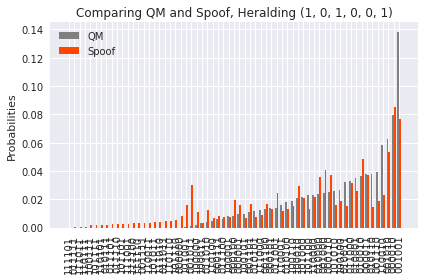

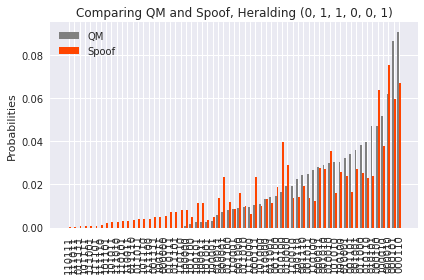

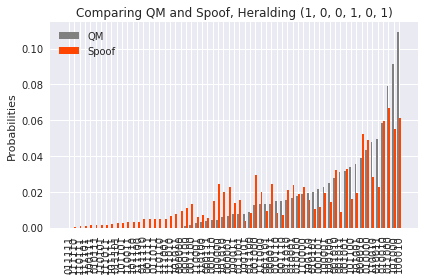

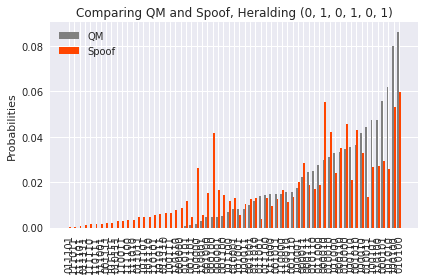

In [54]:
n = 3
# qm_distrs, stoch_distrs = estu(
#     n, 
#     r=0.8, 
#     herald_gamma=2, 
#     out_gamma=1.5, 
#     N=1000000
# )
qm_distrs, stoch_distrs = estu(
    n, 
    r=1.07, 
    herald_gamma=1.9494, 
    out_gamma=1.9494, 
    N=1000000
)

In [ ]:
I1 = np.eye(1)
I2 = np.eye(2)
Z = np.array([[1, 0], [0, -1]])
X = np.array([[0, 1], [1, 0]])
Y = -1j * Z @ X
hadamard = np.array([[1, 1], [1, -1]]) / sqrt(2)

# Basic Hadamard
qm_distrs, stoch_distrs = estu(1, U=hadamard, heralds=[(1,0)], N=1000000)

# Hong-Ou-Mandel Experiment
U = direct_sum(I1, hadamard, I1)
ps = get_fock_basis_states(2, 4) + [(0,1,0,0),(0,0,1,0)]
print(ps)
qm_distrs, stoch_distrs = estu(2, U=U, heralds=[(0,1,1,0)], N=1000000)

In [ ]:
print(stoch_distrs[(0,1,1,0)][(0,0,1,0)])
print(stoch_distrs[(0,1,1,0)][(0,1,0,0)])
print(stoch_distrs[(0,1,1,0)][(0,0,0,0)])

## Temp Header

In [77]:
def get_lossless_estu_heralds(num_src):
    n = num_src
    m = 2*num_src
    
    all_possible_heralds = []
    for i in range(2**n):
        state = [0]*m
        for digit in range(n):
            # each entanglement source either releases H light
            # in both directions or V light in both directions
            ent_index = 2*digit
            h_or_v = (i % 2)
            state[ent_index + h_or_v] = 1
            i >>= 1
        all_possible_heralds.append(tuple(state))
        
    return all_possible_heralds

In [78]:
def qm_estu(U, heralds):
    '''Simulates Quantum Mechanical predictions of detection event likelyhoods
    resulting from passing heralded states through the provided unitary.
    Returns map (heralded_state -> (detection_event -> probability)).
    
    U : m x m matrix
        = unitary to be applied.
    heralds : List(tuple(int)) 
        = list of heralded states.'''

    qm_distrs = defaultdict(lambda: defaultdict(lambda: 0))
    
    hsu = {}

    for initial_state in heralds:
        
        n = sum(initial_state)
        if n not in hsu:
            hsu[n] = HilbertSpaceUnitary(U, n)
        final_state = hsu[n].apply(initial_state)
        
        for fock_outcome in final_state:
            amp = final_state[fock_outcome]
            probability = amp * conj(amp)
            det_event = tuple([(1 if photon_num > 0 else 0) for photon_num in fock_outcome])
            qm_distrs[initial_state][det_event] += probability
    
    return qm_distrs

In [79]:
def stoch_estu(
    U, 
    heralds, 
    r=1, 
    herald_gamma=DEFAULT_MEAS_THRESH, 
    out_gamma=DEFAULT_MEAS_THRESH, 
    N=1000
):
    '''Simulates Stochastic Mechanical predictions of detection event likelyhoods
    resulting from heralding provided states and applying provided unitary.
    Returns map (heralded_state -> (detection_event -> probability)).
    
    U : m x m matrix
        = unitary to be applied.
    heralds : List(tuple(int)) 
        = list of heralded states.
    r : float
        = squeezing strength.
    herald_gamma : float
        = measurement threshold for heralding detectors.
    out_gamma : float
        = measurement threshold for output detectors.
    N : int
        = number of samples.'''
    
    # TODO: change asserts to proper error handling
    m = len(heralds[0])
    assert(m % 2 == 0)
    assert(all([len(herald) == m for herald in heralds]))
    num_src = m // 2
    
    ents = [ent(N, r=r) for i in range(num_src)]
    l_ents = np.concatenate(tuple([ent[0] for ent in ents]))
    r_ents = np.concatenate(tuple([ent[1] for ent in ents]))
    r_ents = U @ r_ents
    dl = threshold_detector(l_ents, herald_gamma)
    dr = threshold_detector(r_ents, out_gamma)
    
    stoch_distrs = defaultdict(lambda: defaultdict(lambda: 0))
    
    for herald in heralds:
        herald_mask = trials_with_outcome(herald, dl)
        counts = Counter(map(tuple, dr.astype(int).T[herald_mask]))
        stoch_normalization = 0
        for det_event in counts.keys():
            stoch_distrs[herald][det_event] = counts[det_event]
            stoch_normalization += counts[det_event]
        if stoch_normalization != 0:
            for det_event in stoch_distrs[herald]:
                stoch_distrs[herald][det_event] /= stoch_normalization
                
    return stoch_distrs

In [80]:
def plot_qm_vs_stoch(qm_distrs, stoch_distrs):
    heralds = set()
    heralds.update(qm_distrs.keys(), stoch_distrs.keys())
        
    for herald in heralds:
        all_det_events = set()
        all_det_events.update(qm_distrs[herald].keys(), stoch_distrs[herald].keys())
        
        distrs_sorted = []
        for det_event in all_det_events:
            distrs_sorted.append(
                (qm_distrs[herald][det_event], 
                 stoch_distrs[herald][det_event], 
                 ''.join(map(str,det_event)))
            )
        distrs_sorted = sorted(distrs_sorted)
    
        labels = []
        qm_data = []
        stoch_data = []
        for qm_pt, stoch_pt, det_event in distrs_sorted:
            labels.append(det_event)
            qm_data.append(qm_pt)
            stoch_data.append(stoch_pt)

        x = np.arange(len(labels))  # the label locations
        width = 0.35  # the width of the bars

        fig, ax = plt.subplots()
        rects1 = ax.bar(x - width/2, qm_data, width, label='QM', color='gray')
        rects2 = ax.bar(x + width/2, stoch_data, width, label='Spoof', color='orangered')

        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel('Probabilities')
        ax.set_title(f'Comparing QM and Spoof, Heralding {herald}')
        ax.set_xticks(x, labels, rotation=90)
        ax.legend()

        #ax.bar_label(rects1, padding=3)
        #ax.bar_label(rects2, padding=3)

        fig.tight_layout()

        plt.show()

In [81]:
def avg_distr_distance(qm_distrs, stoch_distrs):
    heralds = set()
    heralds.update(qm_distrs.keys(), stoch_distrs.keys())
    
    hellinger_dists = []
    
    for herald in heralds:
        all_det_events = set()
        all_det_events.update(qm_distrs[herald].keys(), stoch_distrs[herald].keys())
        obs_pr_distr = []
        exp_pr_distr = []
        for det_event in all_det_events:
            obs_pr_distr.append(stoch_distrs[herald][det_event])
            exp_pr_distr.append(qm_distrs[herald][det_event])
        hellinger_dists.append(hellinger_dist(obs_pr_distr, exp_pr_distr))
        
    return sum(hellinger_dists) / len(hellinger_dists)

In [82]:
def estu(
    num_src,
    U=None, 
    heralds=None, 
    r=1, 
    herald_gamma=DEFAULT_MEAS_THRESH, 
    out_gamma=DEFAULT_MEAS_THRESH, 
    N=1000000
):
    '''Entanglement Sources Through Unitary (ESTU) experiment.
    Defaults to applying Haar-Random Unitary to all possible 
    lossless heralds. No postselection. Converts Fock states
    to 0/1 detection events.'''
    
    n = num_src     # each ent sends one photon to the right
    m = 2*num_src   # two modes exit the right side of each ent (rH,rV)
    
    if U is None:
        U = qr_haar(m)
    if not is_unitary(U):
        raise ValueError('U must be unitary.')
    if U.shape != (m, m):
        raise ValueError(f'Unitary must act on {m} modes.')
    
    if heralds is None:
        heralds = get_lossless_estu_heralds(num_src)
    
    qm_distrs = qm_estu(U, heralds)
    stoch_distrs = stoch_estu(U, heralds, r, herald_gamma, out_gamma, N)

    return qm_distrs, stoch_distrs

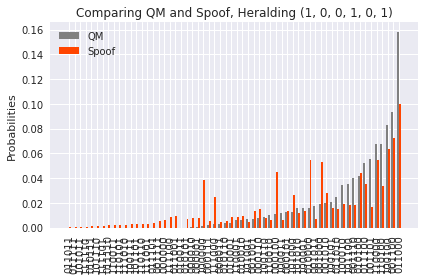

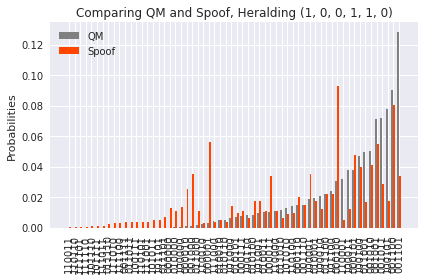

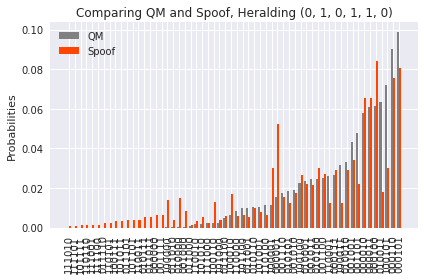

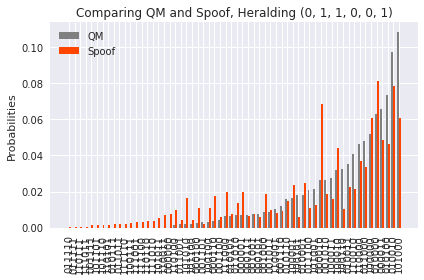

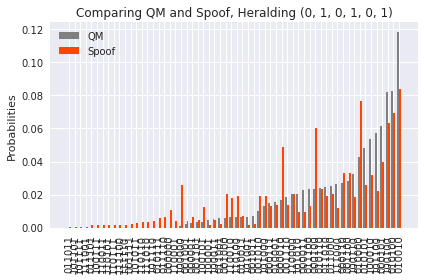

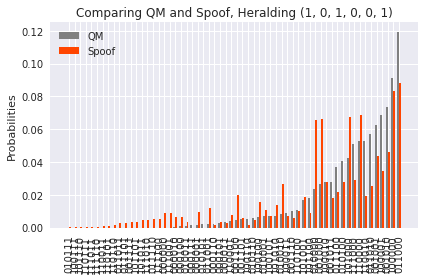

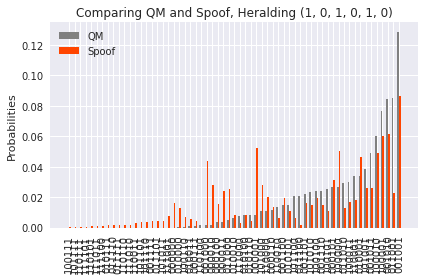

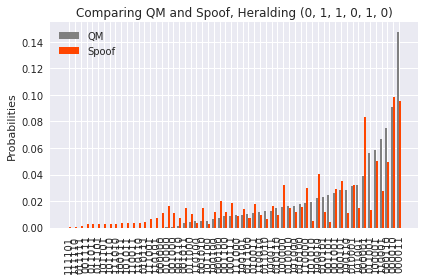

In [84]:
plot_qm_vs_stoch(*estu(3))